# Mask R-CNN Training Demo

This notebook demonstrates the steps for training Mask R-CNN models. 
Mask R-CNN is a convolution-based neural network for the task of object instance segmentation. The original paper describing the model can be found [here](https://arxiv.org/abs/1703.06870). NVIDIA’s Mask R-CNN is an optimized version of [Facebook’s implementation](https://github.com/facebookresearch/maskrcnn-benchmark), leveraging mixed precision arithmetic and tensor cores for faster training times while maintaining comparable accuracy with single precision, i.e. FP32, training.

## Notebook  Content
1. [Pre-requisite: data](#1)
1. [Pre-requisite: container](#2)
1. [Training](#3)
1. [Testing trained model](#4)


<a id="2"></a>
## 1. Pre-requisite: data

This notebook demonstrates training and validation or the Mask R-CNN model on the [COCO 2014 dataset](http://cocodataset.org/#download). If not already available locally, the following [script](../../download_dataset.sh) in this repository provides a convinient way to download and extract all the necessary data in one go:

```
./download_dataset.sh /path/to/coco-2014
```

This script can be executed on a Linux host machine. Be mindful of the size of the raw data (~20GB). The script makes use of `wget` and will automatically resume if disrupted. Once downloaded, the script invokes `dtrx` to extract the data. The final data directory should look like:

```
/path/to/coco-2014
  annotations/
    instances_train2014.json
    instances_val2014.json
  train2014/
    COCO_train2014_*.jpg
  val2014/
    COCO_val2014_*.jpg
```

<a id="2"></a>
## 2. Pre-requisite: container

The most convinient way to make use of the NVIDIA Mask R-CNN model is via a docker container, which provides a self-contained, isolated and re-producible environment for all experiments. First, clone this repository:

```
git clone https://github.com/NVIDIA/DeepLearningExamples.git
cd DeepLearningExamples/PyTorch/Segmentation/MaskRCNN
```

Next, build the NVIDIA Mask R-CNN container:

```
cd pytorch
docker build --rm -t nvidia_joc_maskrcnn_pt .
```

Then launch the container with:

```
PATH_TO_COCO='/path/to/coco-2014'
MOUNT_LOCATION='/datasets/data'
NAME='nvidia_maskrcnn'

docker run --it --runtime=nvidia -p 8888:8888 -v $PATH_TO_COCO:/$MOUNT_LOCATION --rm --name=$NAME --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 --ipc=host nvidia_joc_maskrcnn_pt
```

Within the docker interactive bash session, start Jupyter with

```
jupyter notebook --ip 0.0.0.0 --port 8888  --allow-root --NotebookApp.token=''
```

Then open the Jupyter GUI interfact on your host machine at http://localhost:8888. Within the container, this notebook it-self is located at `/workspace/object_detection/demo`.

We verify that the data has been properly downloaded and mounted.

In [1]:
!ls /datasets/data -l

total 20012368
drwxr-xr-x 2 218419156 1876110778        4096 Jun  3 04:53 annotations
drwxr-xr-x 2 root      root              4096 Jun  3 04:53 annotations.1
-rw-rw-r-- 1      1002       1002   252872794 Jul 10  2018 annotations_trainval2014.zip
-rw-rw-r-- 1      1002       1002    77061279 Dec 21 05:20 coco_annotations_minival.tgz
drwxrwxr-x 2 root      root           4763648 Aug 15  2014 train2014
-rw-rw-r-- 1      1002       1002 13510573713 Jul 11  2018 train2014.zip
drwxrwxr-x 2 root      root           2351104 Aug 15  2014 val2014
-rw-rw-r-- 1      1002       1002  6645013297 Jul 11  2018 val2014.zip


<a id="3"></a>
## 3. Training

The [scripts/train.sh](../scripts/train.sh) provides a convenient interface to launch training tasks. 

### Training with 8 GPUs

By default,  [scripts/train.sh](../scripts/train.sh) makes use of 8 GPUs, saves checkpoints every 2500 iterations and use mixed precision training. If you don't have 8 GPUs, just skip this step and follow along.

In [ ]:
%%bash
cd /workspace/object_detection/
bash scripts/train.sh

Nothat, within [scripts/train.sh](../scripts/train.sh), it runs the following Python command:

```python -m torch.distributed.launch --nproc_per_node=8 tools/train_net.py --config-file "configs/e2e_mask_rcnn_R_50_FPN_1x.yaml"```

which launches pytorch distributed training with 8 GPUs, using the train script in [tools/train_net.py](../tools/train_net.py). Various configuration for the training is set within the [configs](../configs) directory, for example, training using 1 GPU  [configs/e2e_mask_rcnn_R_50_FPN_1x_1GPU.yaml](../configs/e2e_mask_rcnn_R_50_FPN_1x_1GPU.yaml). 

### Training with 1 GPU
We will now take a closer look at training a Mask-RCNN model using 1 GPU, using the below config script.

In [9]:
%%bash
cd  /workspace/object_detection/

echo 'MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "catalog://ImageNetPretrained/MSRA/R-50"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
    OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATASETS:
  TRAIN: ("coco_2014_train", "coco_2014_valminusminival")
  TEST: ("coco_2014_minival",)
DATALOADER:
  SIZE_DIVISIBILITY: 32
SOLVER:
  BASE_LR: 0.005
  WEIGHT_DECAY: 0.0001
  STEPS: (240000, 320000)
  MAX_ITER: 360000
  IMS_PER_BATCH: 4
TEST:
  IMS_PER_BATCH: 16
' > configs/custom_config.yml

Various configurable options within the above configuration file can be modified, for example, the learning rate `BASE_LR`, training batch size `IMS_PER_BATCH` or number of train iterations `MAX_ITER`. The training process will start from a pre-trained Resnet-50 backbone model downloaded from `https://dl.fbaipublicfiles.com/detectron/ImageNetPretrained/MSRA/R-50.pkl`.

Next, we launch the training script using the [custom configuration script](../configs/custom_config.yml) just created above. A full training cycle with 360000 iterations on the COCO-2014 data on a single GPU might take as much as 1.5 day. 

In [ ]:
%run ../tools/train_net.py --config-file "../configs/custom_config.yml"

Upon completion, the final model is saved to `./model_final.pth`.

### Training with 4 GPU
We will now configure a training script to train a Mask-RCNN model using 4 GPUs. Thanks to having 4 GPUs, we can reduce the number of training iterations by a factor of 4, while the learning rate is also increased by 4 times to account for the larger global batch size.

In [ ]:
%%bash
cd  /workspace/object_detection/

echo 'MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "catalog://ImageNetPretrained/MSRA/R-50"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
    OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATASETS:
  TRAIN: ("coco_2014_train", "coco_2014_valminusminival")
  TEST: ("coco_2014_minival",)
DATALOADER:
  SIZE_DIVISIBILITY: 32
SOLVER:
  BASE_LR: 0.02
  WEIGHT_DECAY: 0.0001
  STEPS: (120000, 160000)
  MAX_ITER: 180000
  IMS_PER_BATCH: 4
TEST:
  IMS_PER_BATCH: 16
' > configs/custom_config_4_GPUs.yml

In [ ]:
%run -m torch.distributed.launch -- --nproc_per_node=4 ../tools/train_net.py --config-file "../configs/custom_config_4_GPUs.yml"

<a id="4"></a>
## 4. Testing trained model

After model training has completed, we can test the trained model against the COCO-2014 validation set. First, we create a new configuration file for the test. Note that the model weight now point to `./model_final.pth`.

In [8]:
%%bash
cd  /workspace/object_detection/

echo 'MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  WEIGHT: "./model_final.pth"
  BACKBONE:
    CONV_BODY: "R-50-FPN"
    OUT_CHANNELS: 256
  RPN:
    USE_FPN: True
    ANCHOR_STRIDE: (4, 8, 16, 32, 64)
    PRE_NMS_TOP_N_TRAIN: 2000
    PRE_NMS_TOP_N_TEST: 1000
    POST_NMS_TOP_N_TEST: 1000
    FPN_POST_NMS_TOP_N_TEST: 1000
  ROI_HEADS:
    USE_FPN: True
  ROI_BOX_HEAD:
    POOLER_RESOLUTION: 7
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    POOLER_SAMPLING_RATIO: 2
    FEATURE_EXTRACTOR: "FPN2MLPFeatureExtractor"
    PREDICTOR: "FPNPredictor"
  ROI_MASK_HEAD:
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    FEATURE_EXTRACTOR: "MaskRCNNFPNFeatureExtractor"
    PREDICTOR: "MaskRCNNC4Predictor"
    POOLER_RESOLUTION: 14
    POOLER_SAMPLING_RATIO: 2
    RESOLUTION: 28
    SHARE_BOX_FEATURE_EXTRACTOR: False
  MASK_ON: True
DATASETS:
  TRAIN: ("coco_2014_train", "coco_2014_valminusminival")
  TEST: ("coco_2014_minival",)
DATALOADER:
  SIZE_DIVISIBILITY: 32
SOLVER:
  BASE_LR: 0.005
  WEIGHT_DECAY: 0.0001
  STEPS: (240000, 360000)
  MAX_ITER: 360000
  IMS_PER_BATCH: 4
TEST:
  IMS_PER_BATCH: 16
' > configs/test_custom_config.yml

### Validating on the COCO-2014 mini evaluation data set
Next, we launch the evaluation script, which will read the COCO-2014 mini evaluation dataset of 5000 images and evaluate various quality metrics, such as recall, precision and IoU at various thresholds.

In [ ]:
%run ../tools/test_net.py \
    --config-file ../configs/test_custom_config.yml \
    DTYPE "float16" \
    DATASETS.TEST "(\"coco_2014_minival\",)" \
    OUTPUT_DIR $FOLDER \
    TEST.IMS_PER_BATCH 1

### Testing on new images

We will now launch an interactive testing, where you can load new test images. First, we load some required libraries and define some helper functions to load images.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

Next, we load the trained model.

In [ ]:
print(os.getcwd())
config_file = "../configs/test_custom_config.yml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])

coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

User now can load a test image from any public URL.

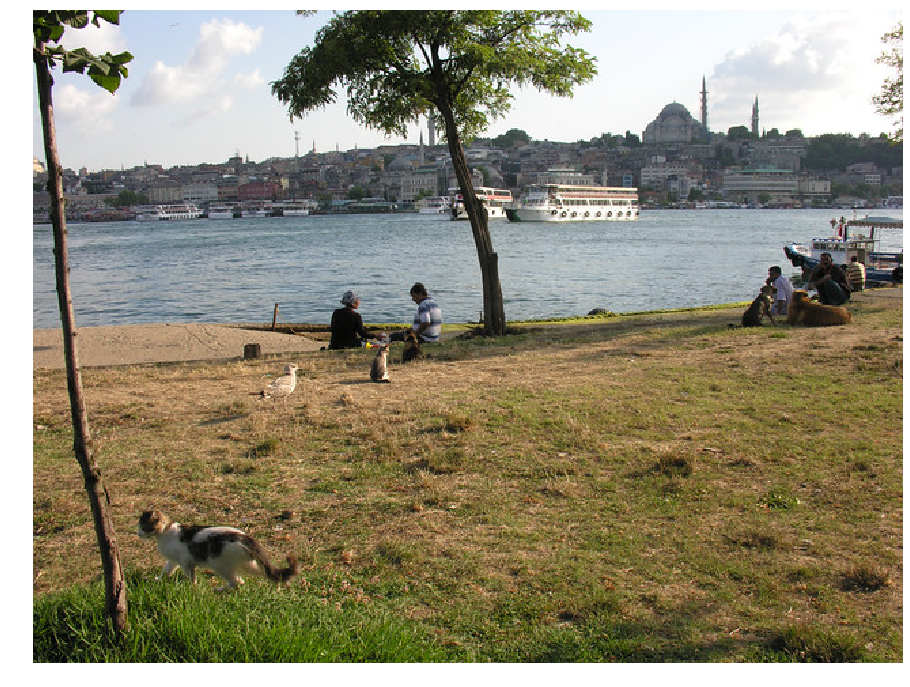

In [22]:
# from http://cocodataset.org/#explore?id=345434
image = load("http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg")
imshow(image)


The prediction result is then displayed.

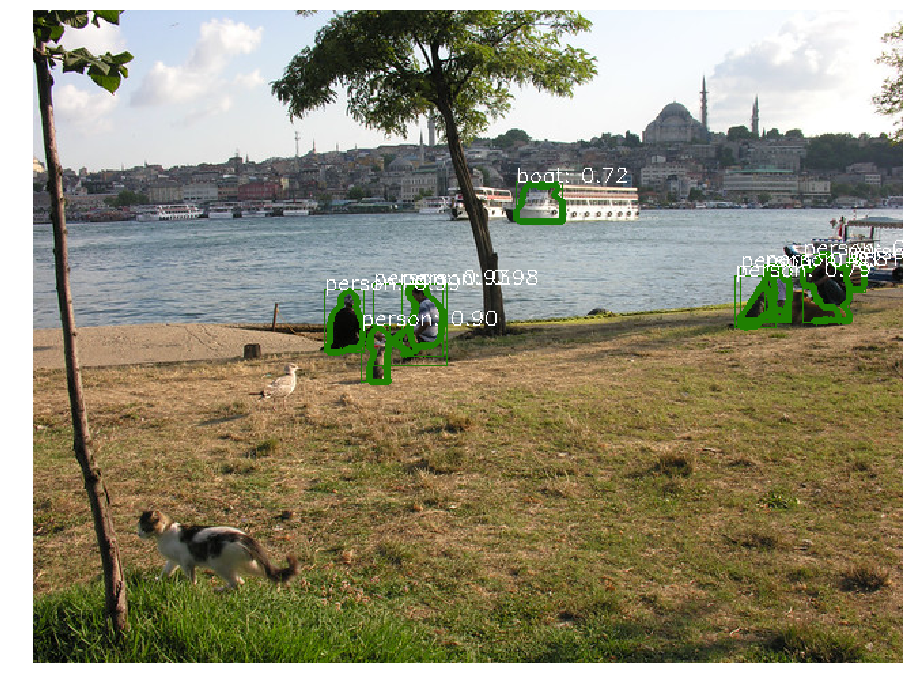

In [25]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

# Conclusion

In this notebook, we have walked through the complete process of preparing the container and data required for training Mask-RCNN models. We have also investigated various training options, trained and tested a Mask-RCNN model,
